### Scheduler.py

In [38]:
# scheduler.py
from mesa.time import RandomActivation
from collections import defaultdict


# Copy from WolfSheep Example.
# In Mesa, multiple agents including the patch, need to written as breed.
# Otherwise, a method is needed for each agent to identify their type.

class RandomActivationByBreed(RandomActivation):
    """
    """
    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(dict)

    def add(self, agent):
        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_breed[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        del self._agents[agent.unique_id]
        agent_class = type(agent)
        del self.agents_by_breed[agent_class][agent.unique_id]

    def step(self, by_breed=True):
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        agent_keys = list(self.agents_by_breed[breed].keys())
        random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].step()

    def get_breed_count(self, breed_class):
        return len(self.agents_by_breed[breed_class].values())

### Model.py

In [39]:
# model.py
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random 
import math
from math import hypot

#calculate percentage of unhappy agents or absolute number of agents in each income groups 
def datagenerator(income, percentage):
    
    def compute(model):
        Number = len([agent.happy for agent in model.schedule.agents 
                    if type(agent) is PeopleAgent and agent.income == income and agent.happy == False])
        if percentage:
            return Number/model.schedule.get_breed_count(PeopleAgent)
        else:
            Number = len([agent.happy for agent in model.schedule.agents 
                    if type(agent) is PeopleAgent and agent.income == income])
            return Number
    return compute

#calculate a list of percentage of each income group 
def datagenerator2(income):
    
    def compute2(model):
        
        halfwidth = int(model.width/2)
        center = halfwidth-0.5
        
        thresholds = [math.hypot(halfwidth + j - center, halfwidth + j - center) for j in range(halfwidth)]
    
        pctlst = []
        
        for i in thresholds:
            totalsubgrp = []
            totaldensity = [0.0001]
            for agent in model.schedule.agents:
                if type(agent) is PatchAgent and math.hypot(agent.pos[0] - center, agent.pos[1] - center) <= i:
                    if income == 1:
                        totalsubgrp.append(agent.Npoor)
                    elif income == 2:
                        totalsubgrp.append(agent.Nmid)
                    else: 
                        totalsubgrp.append(agent.Nrich)
                    totaldensity.append(agent.density)
            pctlst.append(sum(totalsubgrp)/sum(totaldensity))
                
        return pctlst
        
    return compute2

def testOuterRing(income):
    
    def compute3(model):
        counter = 0
        for agent, x, y in model.grid.coord_iter():
            if type(agent) is PeopleAgent and agent.income is income and x is 0 or x is 9 or y is 0 or y is 9:
                counter += 1
        return counter
        
    return compute3

            
class BurgessModel(Model):
    
    
    def __init__(self, N, width, height):
        #super().__init__(seed)
        self.width = width
        self.height = height
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivationByBreed(self)
        self.running = True
            
        # Add the agent to a random grid cell
        def createagent(peopletype): 
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            a = PeopleAgent(id, peopletype, (x, y), self)
            self.schedule.add(a)
            self.grid.place_agent(a, (x, y))
    
        # Creat Patches 
        id = N
        for agent, x, y in self.grid.coord_iter():
            id += 1
            patch = PatchAgent(id, (x, y), self)
            self.grid.place_agent(patch, (x, y))
            self.schedule.add(patch)
            
        # Create People Agents
        id = 0
        for i in range(N - (N//9 + N//9*3)):
            id += 1
            createagent("poor")
        for i in range(N//9*3):
            id += 1
            createagent("middle")
        for i in range(N//9):
            id += 1
            createagent("rich")
            
        #create datacollector 
        self.datacollector = DataCollector(
            model_reporters={"UnhappyPoor": datagenerator(1,True), 
                             "UnhappyMid": datagenerator(2,True), 
                             "UnhappyRich": datagenerator(3,True)
                            })  
        self.computeN = DataCollector(
            model_reporters={"NPoor": datagenerator(1,False), 
                             "NMid": datagenerator(2,False), 
                             "NRich": datagenerator(3,False)
                            }) 
        self.computePctDistance = DataCollector(
            model_reporters={"PctDistancePoor": datagenerator2(1),
                             "PctDistanceMid": datagenerator2(2),
                             "PctDistanceRich": datagenerator2(3)
                            })
        self.computeTest = DataCollector(
            model_reporters={"outerPoor": testOuterRing(1),
                             "outerMid": testOuterRing(2),
                             "outerRich": testOuterRing(3)
                            })
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.computeN.collect(self)
        self.computePctDistance.collect(self)
        self.computeTest.collect(self)


### Agents.py

In [40]:
#agents.py 

def matchpatch(pos, model):
    for agent in model.grid.grid[pos[0]][pos[1]]:
        if type(agent) is PatchAgent:
            return agent
    
class PeopleAgent(Agent):
    
    def __init__(self, unique_id, category, pos, model):
        super().__init__(unique_id, model)
        #added a parameter of category 
        self.category = category
        self.model = model
        self.happy = False
        self.overdue = 0
        self.pos = pos
        
        if category == "poor": 
            self.income = 1
            self.dens_sens = 5
        elif category == "middle":
            self.income = 2
            self.dens_sens = 3
        elif category == "rich": 
            self.income = 3
            self.dens_sens = 1
        else: 
            raise Exception("category not found") 
    
    def move(self):
        # for each step of one agent, find possible neighbors within certain radius
        possible_neighbors = self.model.grid.get_neighborhood(
            self.pos,
            True,
            radius = 5,
            include_center=False)
        
        #pick one of the possible steps that has income >= Lprice, dens_sens >= density, (later job_probs)
        #the patch that has the same location as step
        
        new_position = False
        
        while possible_neighbors:
            neighbor = random.choice(possible_neighbors)
            possible_neighbors.remove(neighbor)
            patch = matchpatch(neighbor, self.model)
            if self.income >= patch.Hprice and random.random() <= patch.jobs_prob and self.dens_sens >= patch.density:
                new_position = neighbor
                break
        if new_position:
            self.model.grid.move_agent(self, new_position)
            self.pos = new_position 
            self.overdue = 0
        else:
            self.overdue += 1
            self.model.schedule.remove(self)
            if self.overdue >= 3:
                self.model.schedule.remove(self)
                
    #update agent happiness
    def updatehappiness(self):
        patch = matchpatch(self.pos, self.model)
        self.happy = self.income >= patch.Hprice and random.random() <= patch.jobs_prob and self.dens_sens >= patch.density
        
    def step(self):
        # check if income still higher than Lprice and job maintains
        self.updatehappiness()
        if not self.happy: 
            self.move()
        self.updatehappiness()
        pass


class PatchAgent(Agent):
    
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.model = model 
        self.pos = pos
        self.Npoor = 0
        self.Nmid = 0
        self.Nrich = 0

        #assume the range of CBD, urban, suburban is 2:4:4 (arbitrary)
        width = self.model.width
        lt_exp = width/2 - 1 #4
        rt_exp = width/2 #5
        rt_mid = rt_exp + width/5 #7
        lt_mid = lt_exp - width/5 #2
        x = self.pos[0]
        y = self.pos[1]
        
        #-------- Assign job probability and land price distribution ----------. 
        #high
        if rt_exp >= x >= lt_exp and rt_exp >= y >= lt_exp: 
            
            #high job distribution
            self.jobs_prob = random.normalvariate(0.7, 0.1)
            
            #80% chance of having the most expensive price (arbitrary)
            if random.random() >= 0.2:
                self.Lprice = 3
            else:
                self.Lprice = 2
        #low
        elif ((lt_mid > x >= 0 or width -1 >= x > rt_mid) and (width - 1 >= y >= 0)) or ((lt_mid > y >= 0 or width - 1 >= y > rt_mid) and (width - 1 >= x >= 0)):
            self.jobs_prob = self.jobs_prob = random.normalvariate(0.3, 0.1)
            self.Lprice = random.randint(1,2)
            
        #middle
        else:
            self.Lprice = random.randint(2,3)
            self.jobs_prob = random.normalvariate(0.5, 0.1)
            
        # ---- Caculate the amount of agents on each patch ---------. 
        self.density = len(self.model.grid.grid[self.pos[0]][self.pos[1]])-1 
        #self.density = 0 #in case we do not want Housing price as a factor. add this line.  
        
        # ---- Caculate the Housing price given land price and density -----. (This is quite arbitrary right now)
        if self.density == 0:
            self.Hprice = self.Lprice
        else:
            self.Hprice = self.Lprice/self.density
    
    def step(self):
        #count number of people on the same patch and update density
        #self.density = 0 #in case we do not want density as a factor. add this line. 
        agentsonpatch = self.model.grid.grid[self.pos[0]][self.pos[1]]
        self.density = len(agentsonpatch)-1
        self.Npoor = len([agent for agent in agentsonpatch if type(agent) is PeopleAgent and agent.income == 1])
        self.Nmid = len([agent for agent in agentsonpatch if type(agent) is PeopleAgent and agent.income == 2])
        self.Nrich = len([agent for agent in agentsonpatch if type(agent) is PeopleAgent and agent.income == 3])

### Test run

In [41]:
test = BurgessModel(90,10,10)

In [42]:
for i in range(20):
    test.step()

### Server.py

In [6]:
#server.py

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from mesa.visualization.UserParam import UserSettableParameter

def layout(layout_choice):
    def agent_portrayal(agent):
        if type(agent) is PatchAgent:
            portrayal = {"Shape": "rect",
                         "Filled": "true",
                         "Layer": 0,
                         "w": 1,
                         "h": 1,
                         "Color": "white",
                        }
            if layout_choice == "land_price":
                if agent.Lprice == 3: 
                    portrayal["Color"] = "LightGrey"
                elif agent.Lprice == 2:
                    portrayal["Color"] = "Grey"
                else: 
                    portrayal["Color"] = "black"

            elif layout_choice == "job_prob":
                portrayal["Color"] = "hsl(0, 0%, "+str(agent.jobs_prob * 100)+"%)"

            #a better density calculation can be designed. 
            elif layout_choice == "density":
                portrayal["Color"] = "hsl(0, 0%, "+str(agent.density * 10)+"%)"

            else: raise Exception("Agent Layer not found") 


        elif type(agent) is PeopleAgent: 
            portrayal = {"Shape": "circle",
                         "Filled": "true",
                         "Layer": 1,
                         "r": 0.5}
            if agent.category == 'poor':
                portrayal["Color"] = "red"
            elif agent.category == 'middle':
                portrayal["Color"] = "yellow"
                portrayal["Layer"] = 2
                portrayal["r"] = 0.4
            else: 
                portrayal["Color"] = "green"
                portrayal["Layer"] = 3
                portrayal["r"] = 0.3

        else: raise Exception("Agent Portrayal not found") 

        return portrayal
    return agent_portrayal

#the width and height can only be multiple of 10 because the proportion of low, middle, high job ring and land price ring is distributed according 2:4:4 
width = 10
height = 10 

land_price = CanvasGrid(layout("land_price"), width, height, 350, 350)
job_prob = CanvasGrid(layout("job_prob"), width, height, 350, 350)
density = CanvasGrid(layout("density"), width, height, 350, 350)

pctunhappychart = ChartModule([{"Label": "UnhappyPoor",
                      "Color": "Red"},
                     {"Label": "UnhappyMid",
                      "Color": "Yellow"},
                     {"Label": "UnhappyRich",
                      "Color": "Green"}
                    ],
                    data_collector_name='datacollector')

# nunhappychart = ChartModule([{"Label": "NPoor",
#                        "Color": "Red"},
#                       {"Label": "NMid",
#                       "Color": "Yellow"},
#                       {"Label": "NRich",
#                       "Color": "Green"}
#                     ],
#                     data_collector_name='computeN')

testChart = ChartModule([{"Label": "outerPoor",
                      "Color": "Red"},
                     {"Label": "outerMid",
                      "Color": "Yellow"},
                     {"Label": "outerRich",
                      "Color": "Green"}
                    ],
                    data_collector_name='computeTest')

n_slider = UserSettableParameter("slider", "Number of Agents", 90, 90, 900, 9)

# layout_choice = UserSettableParameter("choice", "Layout Choices", value = "land_price",
#                                       choices = ["land_price", "job_prob", "density"])

userparameters = {"N": n_slider, 
                  "width": width, 
                  "height": height,
                 }

from mesa.visualization.ModularVisualization import VisualizationElement

#personalized web layout in Javascript  
class Reorganize(VisualizationElement):
    def __init__(self):
        self.js_code = """
        canvasbox = document.querySelector('#elements')
        canvasbox.style.width = '1150px';
        allcanvas = document.querySelectorAll('canvas:not(.chartjs-render-monitor)');
        
        var namelist = ["Land Price", "Job Probability", "Density"]
        allcanvas.forEach(
            function (elem, index) {
            var div = document.createElement('div');
            div.style.display = 'inline-block';
            div.style.marginRight = '20px'; 
            div.style.marginBottom = '20px'; 
            div.style.marginTop = '20px';
            div.style.width = '350px';
            canvasbox.insertBefore(div, elem);
            div.appendChild(elem);
            div.appendChild(document.createTextNode(namelist[index]))
            }
        )
        """

JScode = Reorganize()

server = ModularServer(BurgessModel,
                       [land_price, job_prob, density, testChart, JScode],
                       "Burgess Model",
                       userparameters)

In [7]:
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


### Data Analysis

In [43]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import time 
start = time.time() 
#import seaborn as sns 

meanmid = []
meanpoor = []
meanrich = []
varmid = []
varpoor = []
varrich = []
midBoxData = pd.DataFrame()
poorBoxData = pd.DataFrame()
richBoxData = pd.DataFrame()

#100 runs and 50 steps per run 
for i in range(100):
    model = BurgessModel(90,10,10)
    for t in range(50):
        model.step()
        
    model_df = model.datacollector.get_model_vars_dataframe()
    
    mean_mid = np.mean(model_df["UnhappyMid"])
    var_mid = np.var(model_df["UnhappyMid"])
    midBoxData["run"+str(i+1)] = model_df["UnhappyMid"]
    
    mean_poor = np.mean(model_df["UnhappyPoor"])
    var_poor = np.var(model_df["UnhappyPoor"])
    poorBoxData["run"+str(i+1)] = model_df["UnhappyPoor"]
    
    mean_rich = np.mean(model_df["UnhappyRich"])
    var_rich = np.var(model_df["UnhappyRich"])
    richBoxData["run"+str(i+1)] = model_df["UnhappyRich"]
    
    meanmid.append(mean_mid)
    meanpoor.append(mean_poor)
    meanrich.append(mean_rich)
    varmid.append(var_mid)
    varpoor.append(var_poor)
    varrich.append(var_rich)
    
end = time.time()
print(end - start)

81.16215205192566


In [44]:
#percentage over distance metric. 

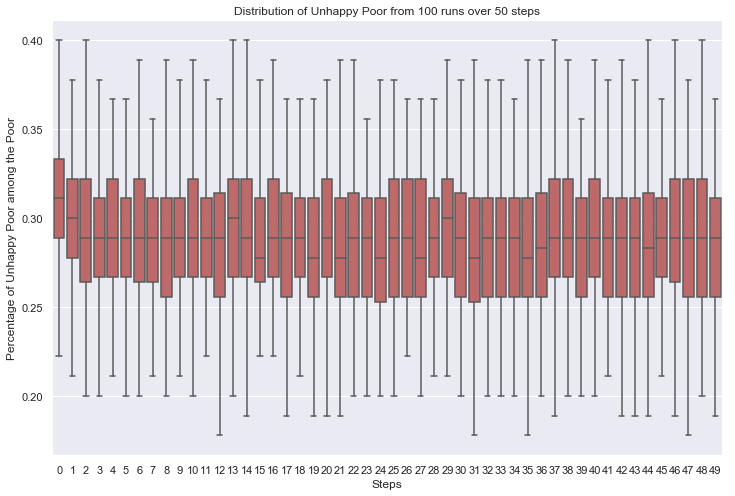

In [45]:
sns.set(rc={'figure.figsize':(12,8)})
plt.title('Distribution of Unhappy Poor from 100 runs over 50 steps')
plt.xlabel('Steps')
plt.ylabel('Percentage of Unhappy Poor among the Poor')
sns.boxplot(data=poorBoxData.T, color="indianred", showfliers=False)

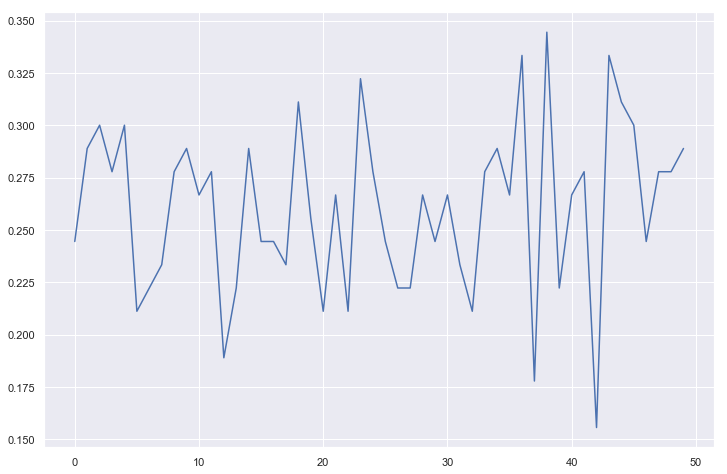

In [46]:
#example of one unhappy poor percentage over time. 
sns.lineplot(data=model_df["UnhappyPoor"])

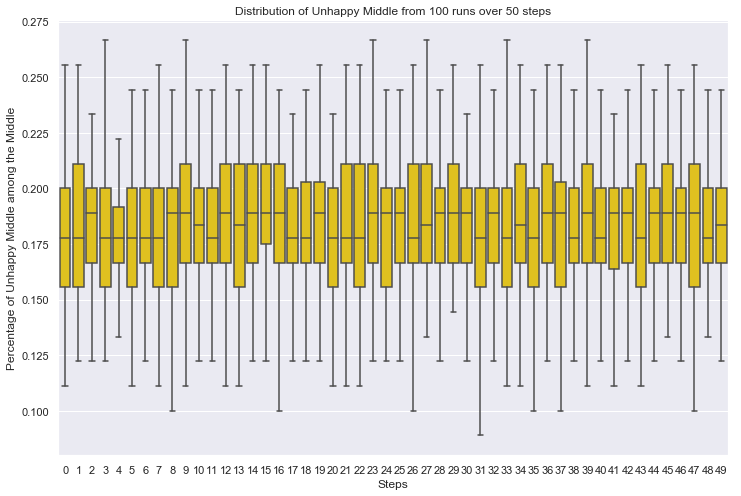

In [47]:
plt.title('Distribution of Unhappy Middle from 100 runs over 50 steps')
plt.xlabel('Steps')
plt.ylabel('Percentage of Unhappy Middle among the Middle')
sns.boxplot(data=midBoxData.T, color="gold", showfliers=False)

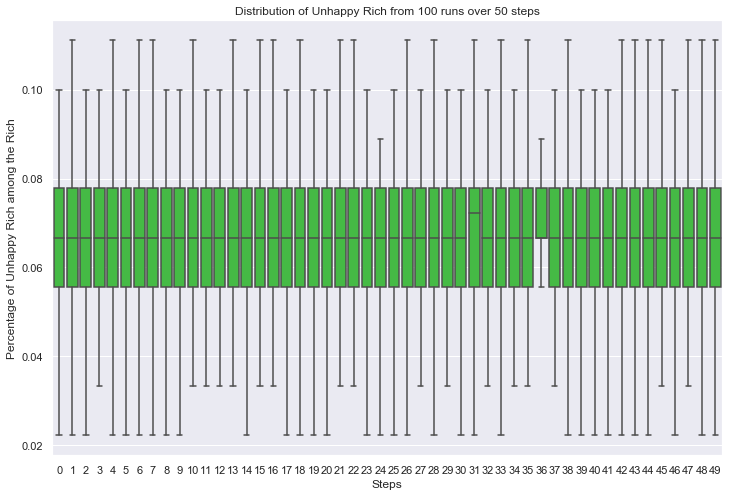

In [55]:
plt.title('Distribution of Unhappy Rich from 100 runs over 50 steps')
plt.xlabel('Steps')
plt.ylabel('Percentage of Unhappy Rich among the Rich')
sns.boxplot(data=richBoxData.T, color="limegreen", showfliers=False)

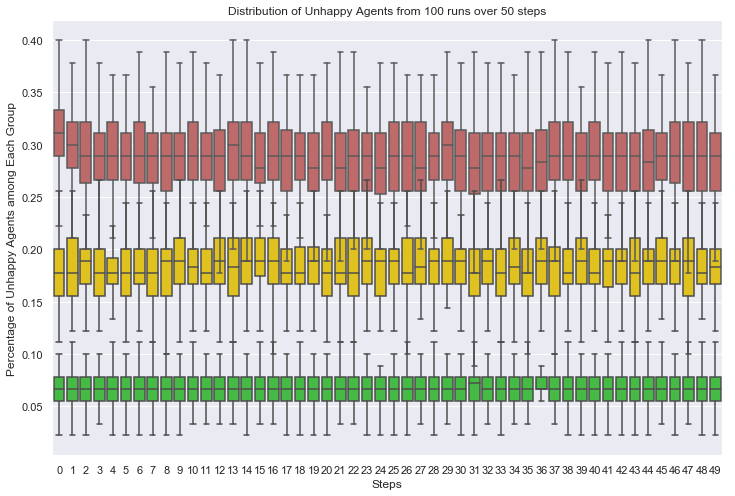

In [56]:
plt.title('Distribution of Unhappy Agents from 100 runs over 50 steps')
plt.xlabel('Steps')
plt.ylabel('Percentage of Unhappy Agents among Each Group')
sns.boxplot(data=poorBoxData.T, color="indianred", showfliers=False)
sns.boxplot(data=midBoxData.T, color="gold", showfliers=False)
sns.boxplot(data=richBoxData.T, color="limegreen", showfliers=False)

In [49]:
model2 = BurgessModel(90,10,10)
for t in range(10):
    model2.step()

model2_df = model2.computePctDistance.get_model_vars_dataframe()
model2_df

,PctDistanceMid,PctDistancePoor,PctDistanceRich
0,"[0.33332962967078145, 0.24999843750976558, 0.2...","[0.6666592593415629, 0.6249960937744139, 0.568...","[0.0, 0.12499921875488279, 0.1568624375246323,..."
1,"[0.24999375015624611, 0.16666574074588475, 0.2...","[0.7499812504687383, 0.7777734568141288, 0.638...","[0.0, 0.05555524691529492, 0.08510620190169807..."
2,"[0.3333277778703688, 0.3333317460393046, 0.327...","[0.6666555557407376, 0.6190446712158514, 0.637...","[0.0, 0.047618820862757795, 0.0344826991677600..."
3,"[0.4285653062099113, 0.34999825000874996, 0.29...","[0.5714204082798817, 0.6499967500162499, 0.639...","[0.0, 0.0, 0.059999880000239994, 0.11249985937..."
4,"[0.33332962967078145, 0.3478245746757623, 0.39...","[0.6666592593415629, 0.6521710775170543, 0.543...","[0.0, 0.0, 0.06521724952771842, 0.105263019390..."
5,"[0.09999900000999991, 0.2499989583376736, 0.29...","[0.8999910000899991, 0.7499968750130208, 0.599...","[0.0, 0.0, 0.10909071074416228, 0.088607482775..."
6,"[0.19999800001999982, 0.22727169421957172, 0.2...","[0.7999920000799993, 0.6818150826587152, 0.703...","[0.0, 0.09090867768782869, 0.07407393690011685..."
7,"[0.21428418368440225, 0.25925829904333686, 0.2...","[0.7857086735094749, 0.6296272976766752, 0.661...","[0.0, 0.11111069959000151, 0.0967740374612299,..."
8,"[0.0, 0.2068958382902128, 0.24193509365307475,...","[0.9999923077514788, 0.7241354340157448, 0.677...","[0.0, 0.06896527943007093, 0.08064503121769158..."
9,"[0.06666622222518517, 0.14285663265488338, 0.2...","[0.9333271111525924, 0.8214256377655794, 0.672...","[0.0, 0.035714158163720845, 0.0655736629939950..."


In [50]:
for i in range(5):
    print(model2_df["PctDistanceMid"][i])

[0.33332962967078145, 0.24999843750976558, 0.2745092656681065, 0.32876667292236583, 0.33333296296337445]
[0.24999375015624611, 0.16666574074588475, 0.2765951561805187, 0.3199995733339022, 0.33333296296337445]
[0.3333277778703688, 0.3333317460393046, 0.3275856420937205, 0.33333290598345383, 0.33333296296337445]
[0.4285653062099113, 0.34999825000874996, 0.29999940000119996, 0.34999956250054687, 0.33333296296337445]
[0.33332962967078145, 0.3478245746757623, 0.39130349716631047, 0.36842056786767385, 0.33333296296337445]


Text(0,0.5,'Percentage of Middle Income Population')

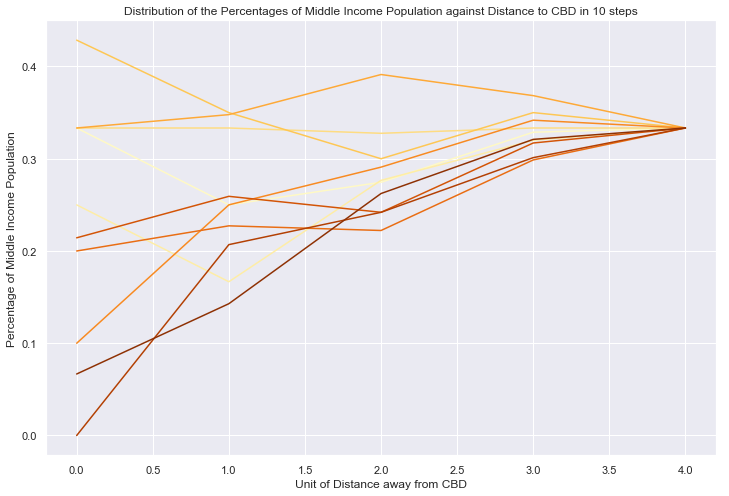

In [51]:
plt.gca().set_prop_cycle('color', [plt.cm.YlOrBr(i) for i in np.linspace(0.1, 0.9, 10)])

for t in range(10):
    sns.lineplot(x=range(5), y=model2_df["PctDistanceMid"][t])
    
plt.title('Distribution of the Percentages of Middle Income Population against Distance to CBD in 10 steps')
plt.xlabel('Unit of Distance away from CBD')
plt.ylabel('Percentage of Middle Income Population')

Text(0,0.5,'Percentage of Low Income Population')

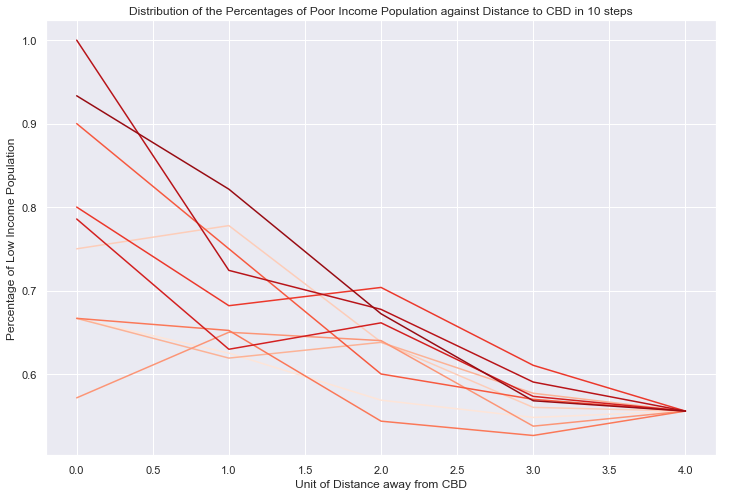

In [52]:
plt.gca().set_prop_cycle('color', [plt.cm.Reds(i) for i in np.linspace(0.1, 0.9, 10)])

for t in range(10):
    sns.lineplot(x=range(5), y=model2_df["PctDistancePoor"][t])
    
plt.title('Distribution of the Percentages of Poor Income Population against Distance to CBD in 10 steps')
plt.xlabel('Unit of Distance away from CBD')
plt.ylabel('Percentage of Low Income Population')

Text(0,0.5,'Percentage of High Income Population')

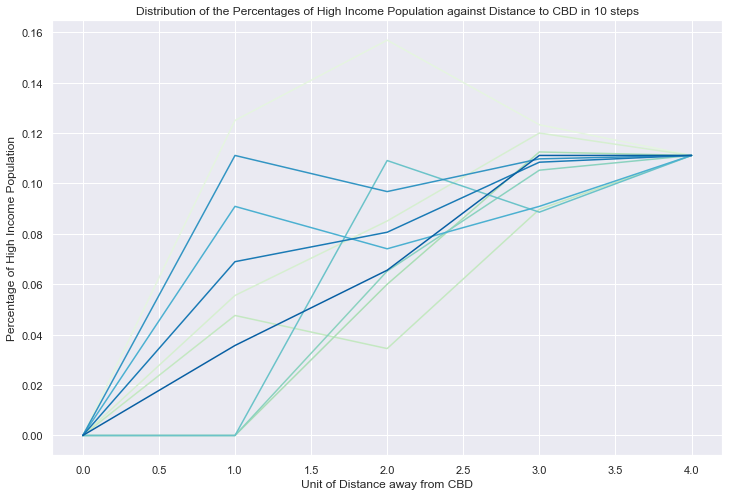

In [53]:
plt.gca().set_prop_cycle('color', [plt.cm.GnBu(i) for i in np.linspace(0.1, 0.9, 10)])

for t in range(10):
    sns.lineplot(x=range(5), y=model2_df["PctDistanceRich"][t])
    
plt.title('Distribution of the Percentages of High Income Population against Distance to CBD in 10 steps')
plt.xlabel('Unit of Distance away from CBD')
plt.ylabel('Percentage of High Income Population')